
## Print figures of Himawari SST data in regions (distributed)


In [1]:
import os,sys
from glob import glob
#
%matplotlib inline
#matplotlib.use('agg')
import matplotlib.pyplot as plt
import xarray as xr
from dask import compute, delayed
from dask.distributed import Client
# 
from datetime import datetime
#
from utils import *

/home1/datahome/aponte/.miniconda3/envs/pangeo/lib/python3.6/site-packages/distributed/utils.py:121: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


satpy not available


/home1/datahome/aponte/.miniconda3/envs/pangeo/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
### get dask handles and check dask server status
client = Client(scheduler_file=os.path.expanduser('/home1/datawork/aponte/dask/scheduler.json'))
client.restart()
# upload utils.py to workers
client.upload_file('utils.py')

In [3]:
client

Client Scheduler: tcp://10.148.1.0:8786 Dashboard: http://10.148.1.0:8787,Cluster Workers: 62 Cores: 248 Memory: 620.00 GB


In [4]:
# data path
region = 'NWA'; vmin = 20.; vmax = 35.
region = 'NWAM'; vmin = 26.; vmax = 32.
region = 'WA'; vmin = 20.; vmax = 35.

#
dpath = '/home/datawork-lops-osi/data/hw/sst/'+region+'/';
#figdir = '/home1/datawork/aponte/hw/figs/'

filenames = sorted(glob(dpath+region+'_*.nc'))
print('Number of files available: %d' %len(filenames))
Nfiles = len(filenames)
# tmp, subset number of files (skip last file that may be incomplete)
#filenames = filenames[:-1]

# consider a time subset
#times = [datetime.strptime(f,dpath+region+'_%Y%m%d%H%M.nc') for f in filenames]

%time ds = xr.open_mfdataset(filenames, concat_dim='time', compat='equals')
ds['sea_surface_temperature'] += -273.15
ds['sea_surface_temperature'] = ds['sea_surface_temperature'].where(ds['sea_surface_temperature']>0)

print('Number of files processed: %d' %len(filenames))

Number of files available: 1843
CPU times: user 28.1 s, sys: 1.92 s, total: 30 s
Wall time: 1min 3s
Number of files processed: 1843


In [5]:
ds

<xarray.Dataset>
Dimensions:                  (lat: 1501, lon: 1001, time: 1843)
Coordinates:
  * lat                      (lat) float32 -10.0 -10.02 -10.04 -10.06 -10.08 ...
  * lon                      (lon) float32 105.0 105.02 105.04 105.06 105.08 ...
  * time                     (time) datetime64[ns] 2016-03-01T00:00:17 ...
Data variables:
    sea_surface_temperature  (time, lat, lon) float64 dask.array<shape=(1843, 1501, 1001), chunksize=(1, 1501, 1001)>
    wind_speed               (time, lat, lon) float64 dask.array<shape=(1843, 1501, 1001), chunksize=(1, 1501, 1001)>
    solar_zenith_angle       (time, lat, lon) float64 dask.array<shape=(1843, 1501, 1001), chunksize=(1, 1501, 1001)>
Attributes:
    Conventions:                CF-1.4,Unidata Observation Dataset v1.0
    title:                      Sea Surface Temperature from AHI onboard Hima...
    summary:                    TBD
    references:                 TBD
    institution:                Japan Aerospace Exploration Ag

---

# mean quantities

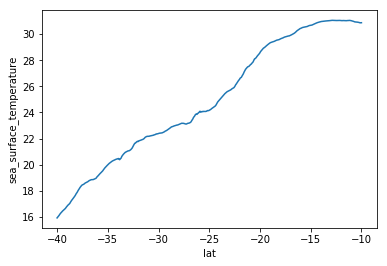

In [6]:
Tmean_xt = ds['sea_surface_temperature'].mean(['lon','time']).persist()
Tmean_xt.plot()

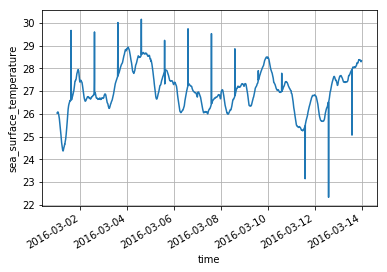

In [7]:
Tmean_xy = ds['sea_surface_temperature'].mean(dim=['lon','lat'])
Tmean_xy.plot()
plt.grid()

In [8]:
Tmean_t = ds['sea_surface_temperature'].mean('time').persist()

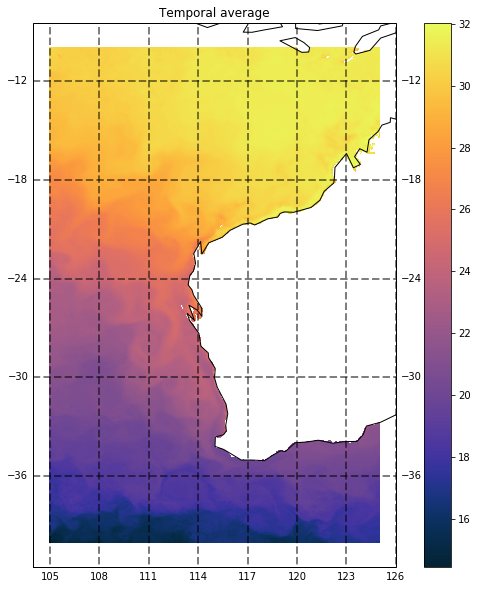

In [9]:
plot_sst(Tmean_t, title='Temporal average')

---

# diurnal cycle

In [10]:
Tdcycle = (ds['sea_surface_temperature'].mean('lon') - Tmean_xt).groupby('time.hour').mean('time')
Tdcycle = Tdcycle.persist()

In [11]:
Tdcycle

<xarray.DataArray 'sea_surface_temperature' (hour: 24, lat: 1501)>
dask.array<shape=(24, 1501), dtype=float64, chunksize=(1, 1501)>
Coordinates:
  * lat      (lat) float32 -10.0 -10.02 -10.04 -10.06 -10.08 -10.1 -10.12 ...
  * hour     (hour) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...

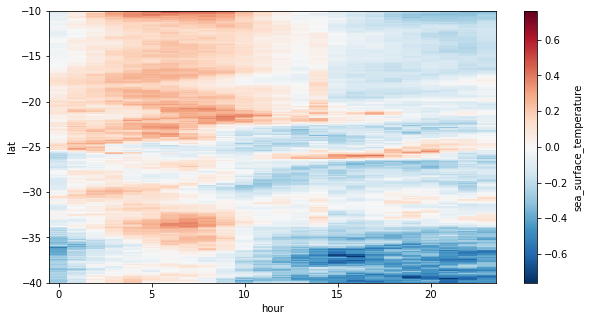

In [12]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
Tdcycle.T.plot(ax=ax)

---

# zonally averaged temperature

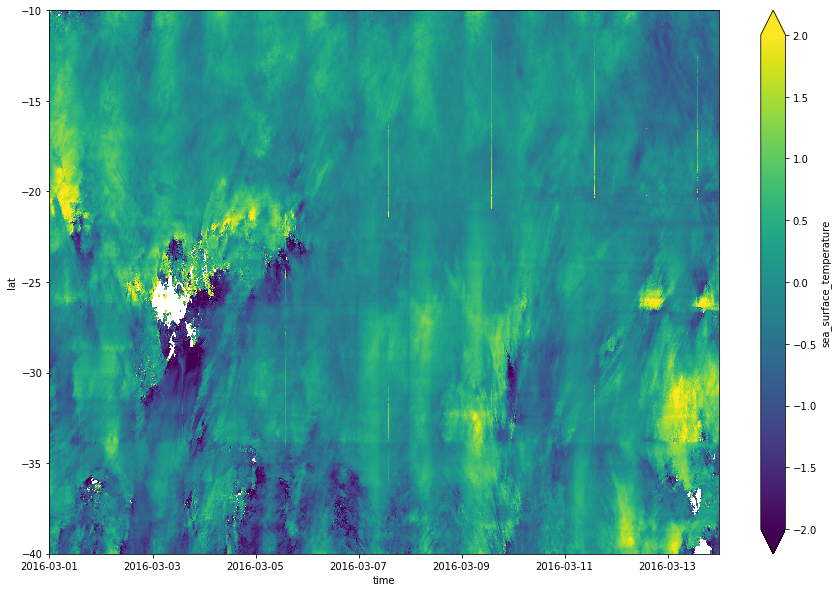

In [13]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
(ds['sea_surface_temperature'].mean('lon') - Tmean_xt).T.plot(ax=ax, vmin=-2., vmax=2.)

---

# At a single latitude

In [14]:
T = ds['sea_surface_temperature'].sel(lat=-26.,method='nearest').sel(lon=slice(105.,115.))
T = T.sel(time=slice('2016-03-06','2016-03-12'))
T += -T.mean('time') 

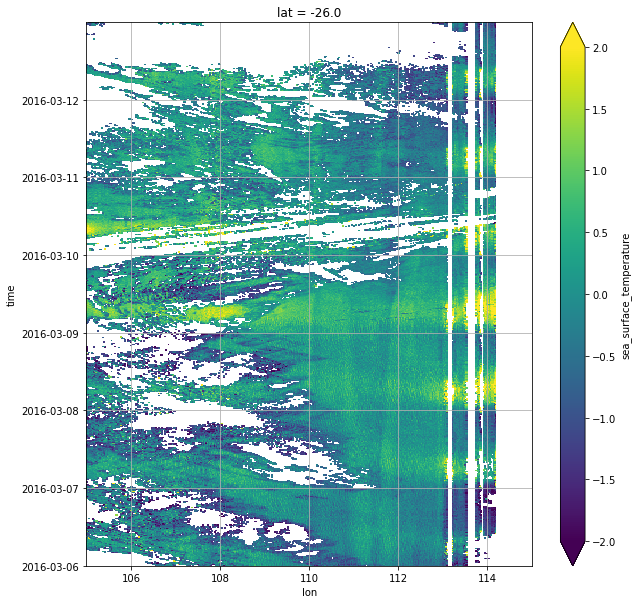

In [15]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
T.plot(ax=ax, vmin=-2., vmax=2.)
ax.grid()